---
title: "Royal Road AB Ad Test"
description: "What are the best sort of ads to run on Royal Road? Meme ads."
date: 2024-01-09
categories: [tutorial]
tags: [statistics]
aliases: ["/rr_ads"]
math: true
---

If you don't know what A/B tests are, feel free to check out [this tutorial](/ab_tests), but to boil it down a sentence: "Do a bunch of things at once and see which is better."

So yeah, I ran 9 ads in parallel. The plan was to run 10, but my "Kindle" word got covered by the "User Ad" rectangle in the overlay, so the ad wasn't approved, and I decided to just forgo it rather than run it at a different time.

Now, the big caveat here is that my story is on Kindle, and clicking outside RR won't be as effective as promoting another RR story.

**TL;DR: Meme ads are king. Ridiculously so.**


In [31]:
import matplotlib.pyplot as plt

plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["hist.bins"] = 50
plt.rcParams["lines.markersize"] = 2
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["font.size"] = 14
plt.rcParams["axes.grid"] = False
plt.rcParams["image.cmap"] = "magma"
plt.rc("text", usetex=False)
plt.rc("font", family="sans-serif")
plt.rcParams["legend.frameon"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams.update(
    {
        "figure.facecolor": (0.0, 0.0, 0.0, 0.0),
        "axes.facecolor": (0.0, 0.0, 0.0, 0.0),
        "savefig.facecolor": (0.0, 0.0, 0.0, 0.0),
    }
)

In [20]:
import pandas as pd
from datetime import datetime as dt
from datetime import timezone as tz
from pathlib import Path
import glob

from zoneinfo import ZoneInfo

aest = ZoneInfo("Australia/Brisbane")
start = dt(2023, 12, 18, 10, tzinfo=aest)

dfs = []
for file in glob.glob("data/*.txt"):
    df = pd.read_csv(file, sep="\t", header=None)
    df.columns = [
        "Title",
        "Views",
        "Views Left",
        "Clicks",
        "CTR",
        "Cost",
        "Status",
        "Start",
        "Actions",
    ]
    time_string = Path(file).stem
    time = dt.strptime(time_string, "%Y-%m-%d_%H%M")
    df["Time"] = time.replace(tzinfo=aest)
    df = df[["Time", "Title", "Clicks", "Views"]]
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df["Title"] = df["Title"].str.replace("SR ", "")
for c in ["Title", "Views", "Clicks"]:
    df[c] = df[c].astype(str).str.strip().str.replace(",", "")
df["Views"] = pd.to_numeric(df["Views"])
df["Clicks"] = pd.to_numeric(df["Clicks"]).astype(int)
df.to_json("data2.json", orient="records", date_format="iso", indent=4)

## The Ads

I wanted to go for a few different categories: text-heavy ads showing story tags, more formal title+cover ads, meme-adjacent ads (like the Bestest Brother one), and full meme ads (the final one).

![](spread.jpg)

Now if you just want to know which ad was best, ad 9, the one in the bottom right corner, destroyed everything else. But if you want to see how the click-throughs compare and changed over time, continue reading. To make things easier, here is each campaign labelled:

![](cover.jpg)

## Performance over time

As typical with RR, we see declining results as we churn through the entire reader base and the target that _would_ have clicked have already done so. This is most prominent with the meme ads, and we can see a drop from an initial click-through rate (CTR) of 2.8% down to 1.7%. I copied and pasted the table out of the RR ad centre eight times over the campaign. The plan was to do it more, but I... forgot. Oops.

Anyway, below you can see both the CTR evolution and the uncertainty in that mean CTR.


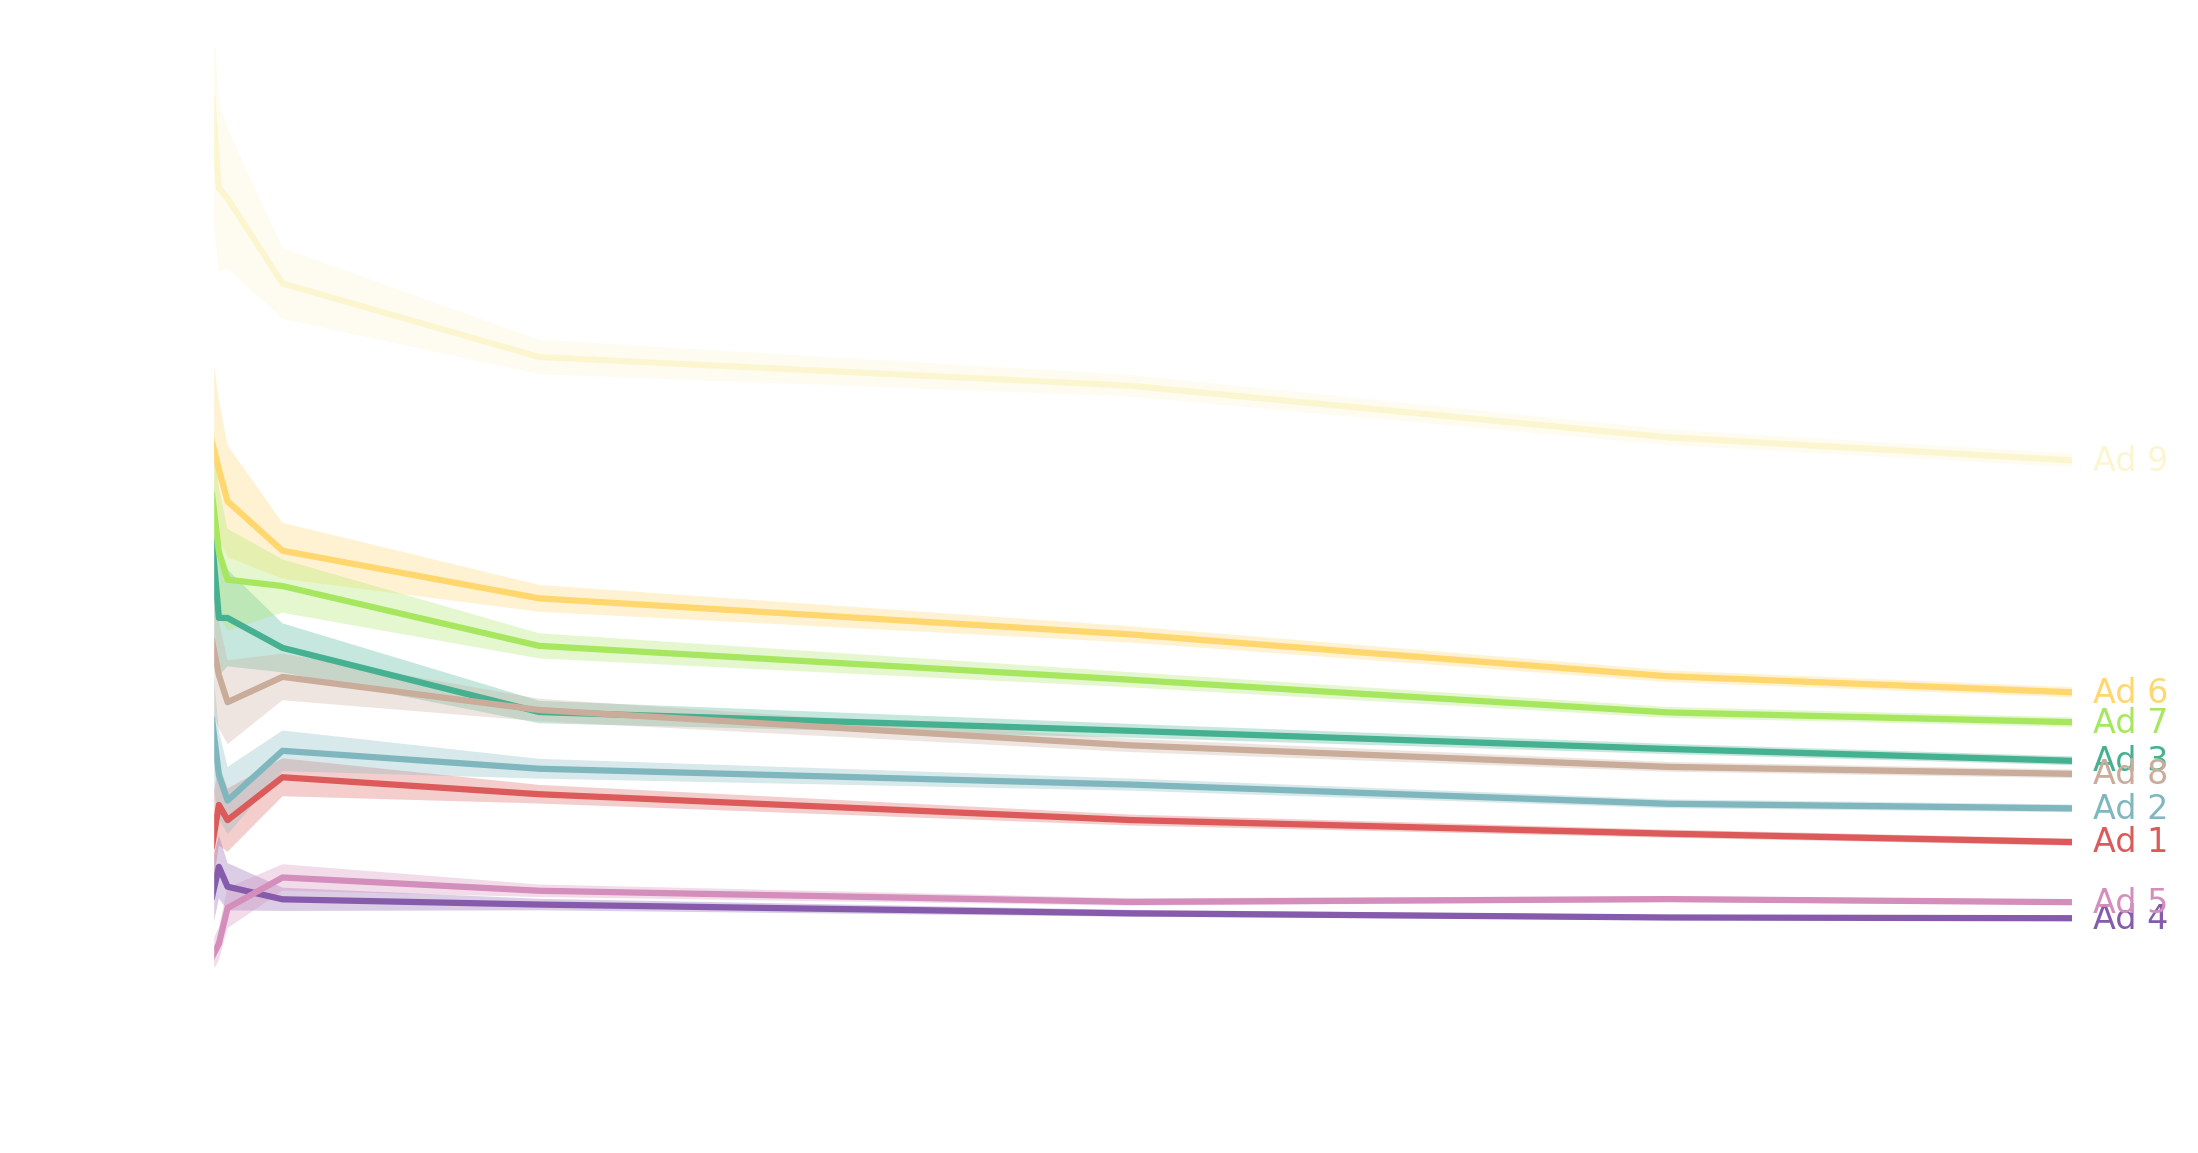

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

colors = {
    1: "#dc5a5a",
    2: "#80b7be",
    3: "#45b191",
    4: "#865bab",
    5: "#d48ebb",
    6: "#ffd76e",
    7: "#a7e75f",
    8: "#c9ac9a",
    9: "#fcf6d0",
}
df = pd.read_json("data.json", orient="records", convert_dates=["Time"])
df = df.sort_values(["Ad", "Time"])
df["CTR"] = df["Clicks"] / df["Views"]
df["CTR_err"] = np.sqrt(df["CTR"] * (1 - df["CTR"]) / df["Views"])

fig, ax = plt.subplots()
for ad, df_ad in df.groupby("Ad"):
    df_ad = df_ad.sort_values("Time")
    ax.plot(df_ad["Time"], df_ad["CTR"] * 100, color=colors[ad])
    ### REMOVE_START
    ax.fill_between(
        df_ad["Time"],
        (df_ad["CTR"] - df_ad["CTR_err"]) * 100,
        (df_ad["CTR"] + df_ad["CTR_err"]) * 100,
        color=colors[ad],
        ec="none",
        alpha=0.3,
    )
    ax.annotate(
        f"Ad {ad}",
        xy=(df_ad["Time"].iloc[-1], df_ad["CTR"].iloc[-1] * 100),
        xytext=(5, 0),
        textcoords="offset points",
        color=colors[ad],
        va="center",
        ha="left",
        fontsize=8,
    )
    ### REMOVE_END

ax.set_ylabel("Total CTR (%)")
ax.set_ylim(0, 3)  ### REMOVE
ax.set_xlabel("Time")
ax.set_xlim(df["Time"].min(), df["Time"].max())  ### REMOVE
ax.xaxis.set_major_locator(plt.MaxNLocator(5))  ### REMOVE

!!! img-large

To me this is pretty clear evidence that you should never spend more than the minimum $50USD and should instead trial ad permutations. Note that what you're seeing above is the **total** CTR. The fact that the meme ad dropped from 2.8% to 1.6% means that the instantaneous CTR at the end must be far lower than 1.6% to get 1.6% as the final average (for the meme ad, the final CTR over the last 5 days is around 1.3%).

If I had better time resolution, I'd plot this. Ah well.

For a final leaderboard:


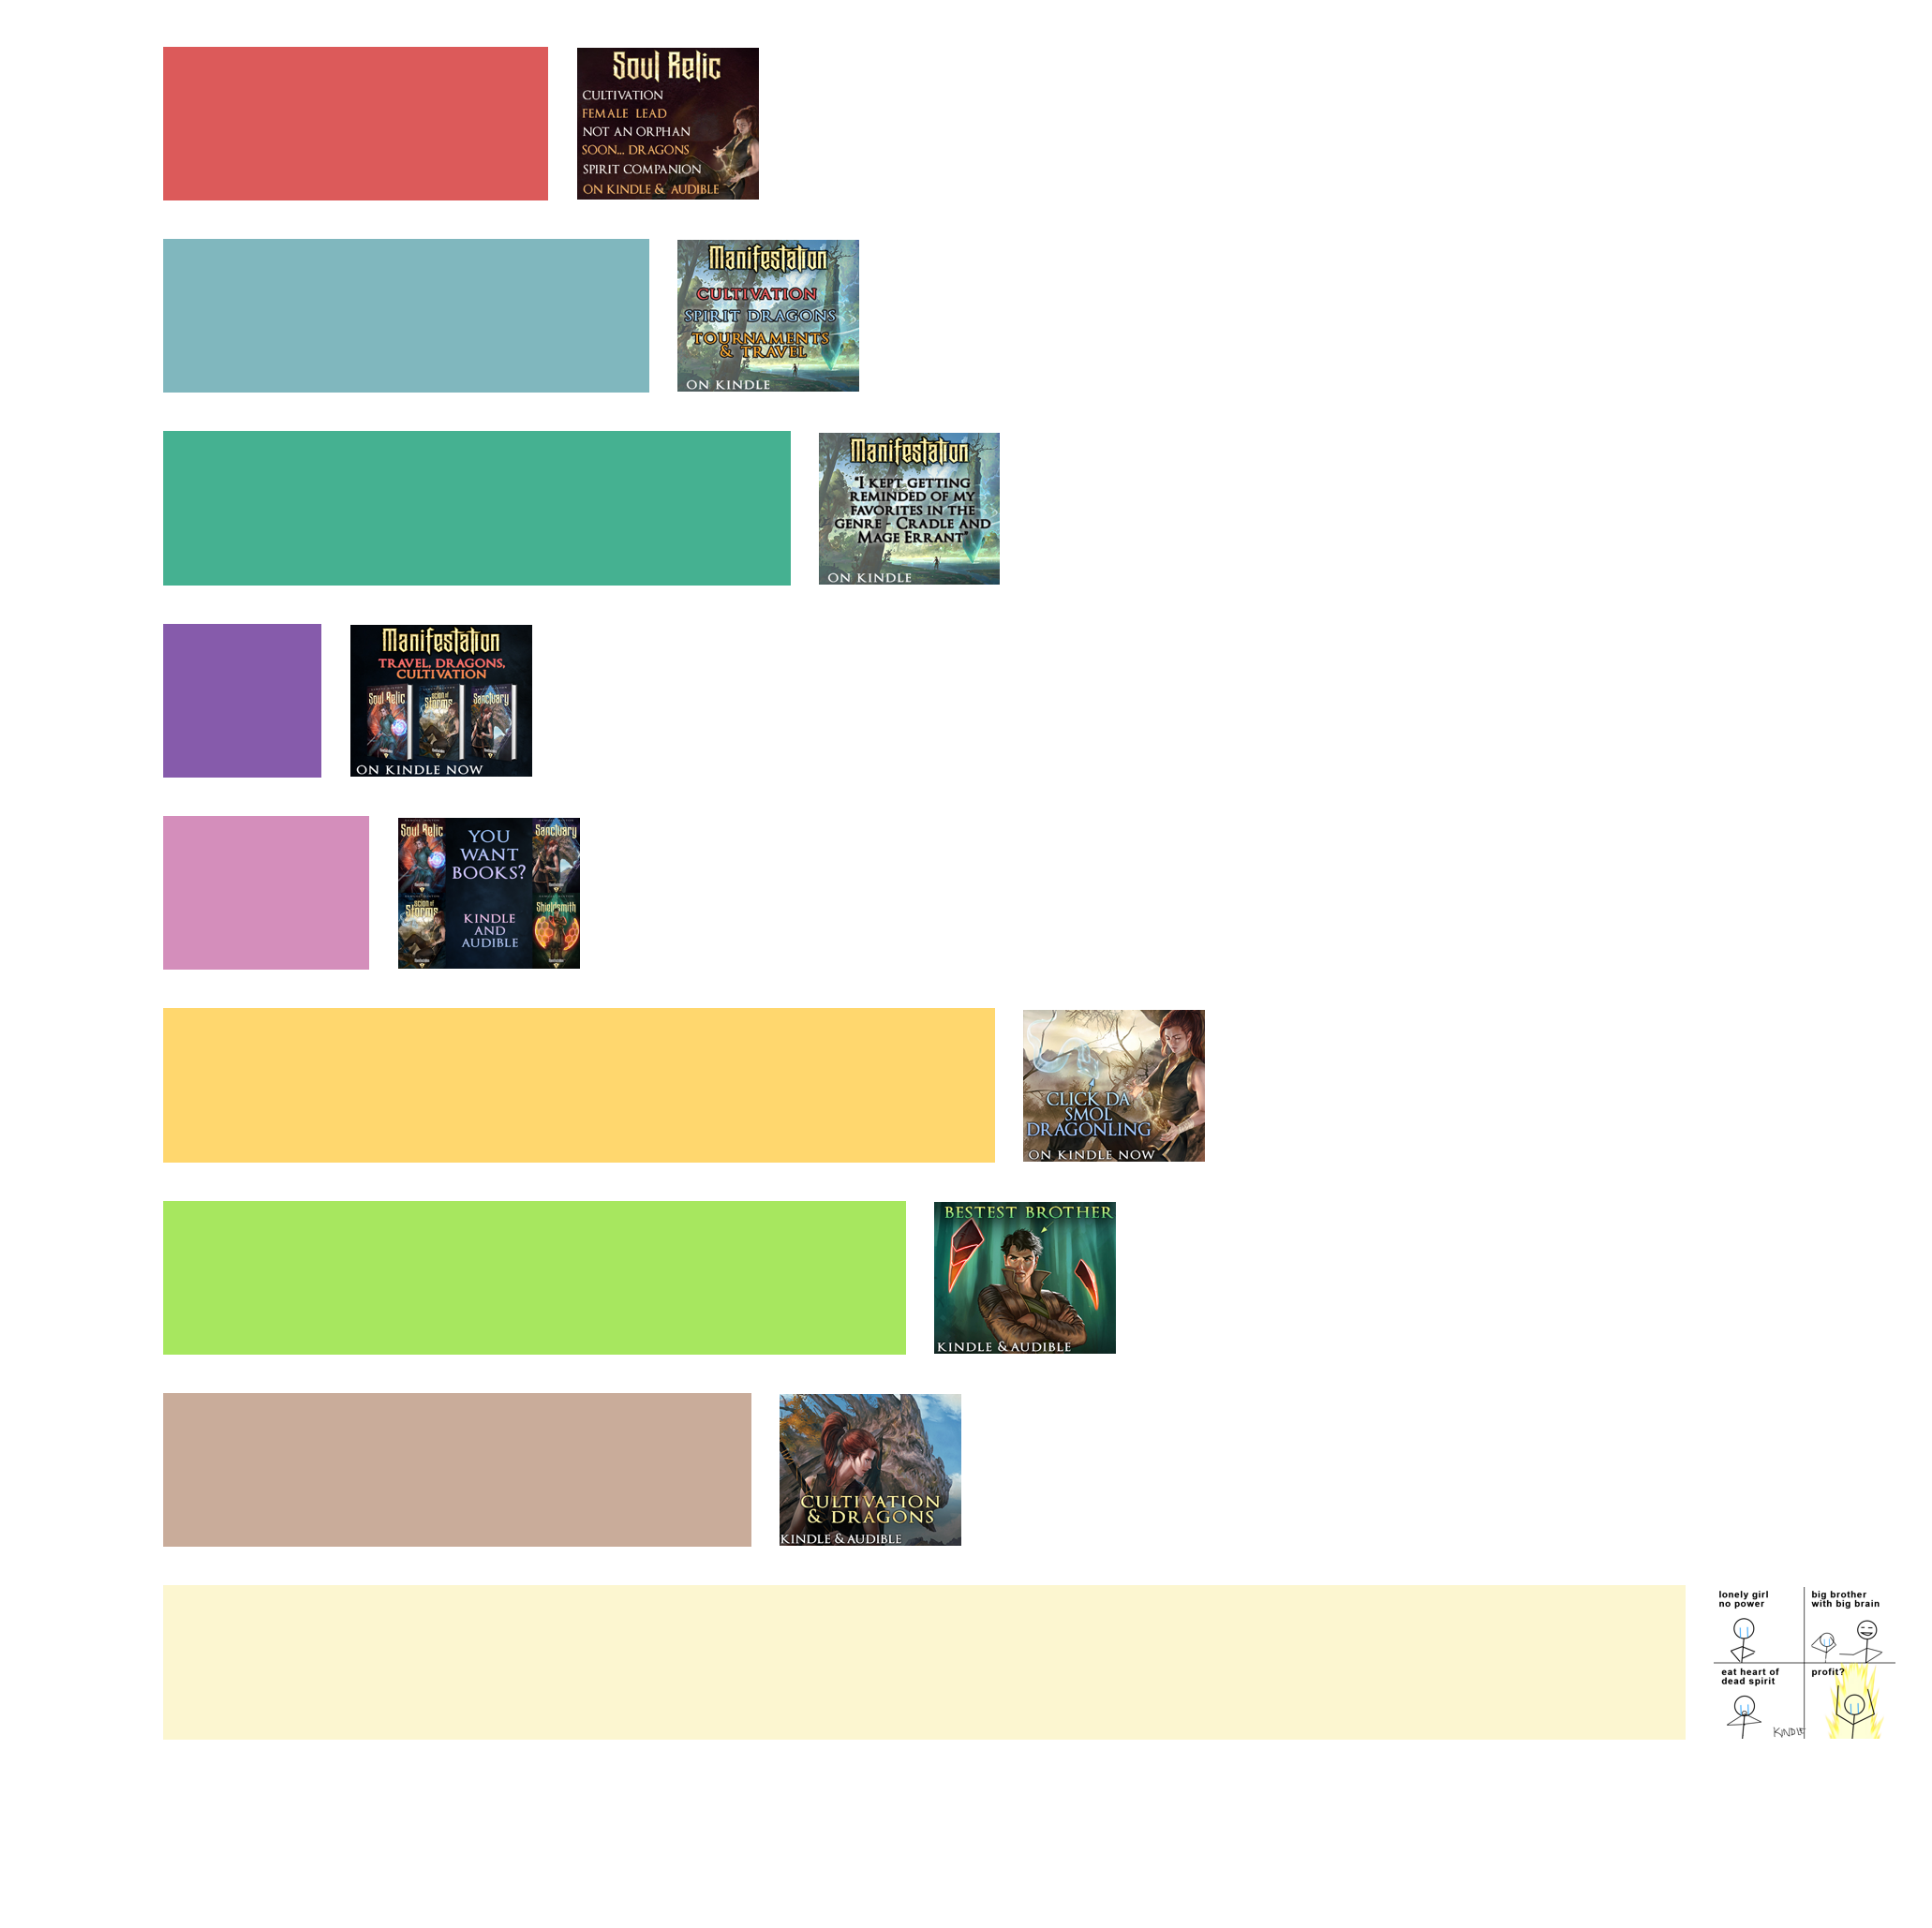

In [129]:
from PIL import Image  ### REMOVE

df_final = df.loc[df["Time"] == df["Time"].max(), ["Ad", "CTR"]]
fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(
    10 - df_final["Ad"],
    df_final["CTR"] * 100,
    color=[colors[ad] for ad in df_final["Ad"]],
)
ax.set_xlabel("Final CTR (%)")
### REMOVE_START
ax.set_yticks(list(range(1, 10)))
ax.set_yticklabels([f"Ad {ad}" for ad in df_final["Ad"][::-1]])

xposs = df_final.set_index("Ad").to_dict()["CTR"]
ax.set_xlim(0, 1.9)
ax.set_ylim(0.5, 9.5)
for i in range(1, 10):
    img = Image.open(f"ad{i}.jpg")
    scale = 0.65
    w, h = (int(300 * scale), int(250 * scale))
    img.thumbnail((w, h))
    xloc = 100 * xposs[i] - 0.1
    yloc = (10 - i) - 0.8
    xpos = ax.transData.transform((xloc, 0))[0]
    ypos = ax.transData.transform((0, yloc))[1]
    ax.figure.figimage(img, xpos, ypos, zorder=1)
### REMOVE_END

Anyway, this took more time and money than I wanted, so here's hoping this is useful for someone!
